In [111]:
# this notebook will take ML approach to predict the futuristic momentum of the stock price

In [112]:
# Step 1: Load and Concatenate All CSV Files
import os
import pandas as pd

# Function to load all CSV files from a directory
def load_data_from_folder(folder_path):
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    data_frames = []

    for file in all_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        data_frames.append(df)

    # Concatenate all dataframes into one
    return pd.concat(data_frames, ignore_index=True)

# Load data from both folders
data_august = load_data_from_folder('data/ETH_2023-08')
data_september = load_data_from_folder('data/ETH_2023-09')

# Combine both datasets
df = pd.concat([data_august, data_september], ignore_index=True)

# Show the first few rows of the combined data
df.head()


,open_time,open,high,low,close,volume,close_time,count
0,1691280000000,1836.48,1836.48,1836.47,1836.48,0.3538,1691280000999,10
1,1691280001000,1836.48,1836.48,1836.47,1836.47,0.4028,1691280001999,5
2,1691280002000,1836.48,1836.48,1836.48,1836.48,0.0854,1691280002999,1
3,1691280003000,1836.48,1836.48,1836.47,1836.47,0.1518,1691280003999,3
4,1691280004000,1836.48,1836.48,1836.48,1836.48,0.0109,1691280004999,1


In [113]:
# Step 2: Data Preprocessing and Feature Engineering
# Now that all the data is loaded, we can proceed with creating features like moving averages, returns, and volatility.

# Create new features for feature engineering
# df['price_return'] = df['close'].pct_change()  # Percentage change in price
df['volatility'] = df['close'].rolling(window=60).std()  # Volatility over the last 60 seconds
# df['volume_return'] = df['volume'].pct_change()  # Percentage change in volume
df['ma_10'] = df['close'].rolling(window=10).mean()  # 10-second moving average
df['ma_30'] = df['close'].rolling(window=30).mean()  # 30-second moving average

# Drop rows with NaN values created by rolling operations
df.dropna(inplace=True)

# Show the data after feature engineering
df.head()


,open_time,open,high,low,close,volume,close_time,count,volatility,ma_10,ma_30
59,1691280059000,1836.30,1836.30,1836.29,1836.30,1.1798,1691280059999,32,0.091856,1836.291,1836.294000
60,1691280060000,1836.30,1836.30,1836.29,1836.30,0.2764,1691280060999,9,0.091435,1836.292,1836.294000
61,1691280061000,1836.30,1836.30,1836.29,1836.29,0.9097,1691280061999,2,0.091245,1836.292,1836.293667
62,1691280062000,1836.29,1836.29,1836.29,1836.29,0.0000,1691280062999,0,0.090759,1836.292,1836.293667
63,1691280063000,1836.29,1836.29,1836.29,1836.29,0.0242,1691280063999,1,0.090360,1836.292,1836.293667


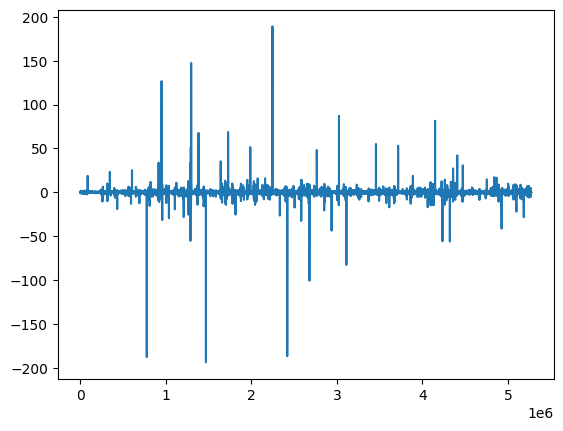

In [114]:
# Step 3: calculate the current trend
import matplotlib.pyplot as plt

lookback_window = 60

# Calculate the current trend
df['current_trend'] = df['close'] - df['close'].shift(lookback_window)

# plot values:
df['current_trend'].plot()
plt.show()

/Users/yarden/opt/anaconda3/envs/job_interview/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


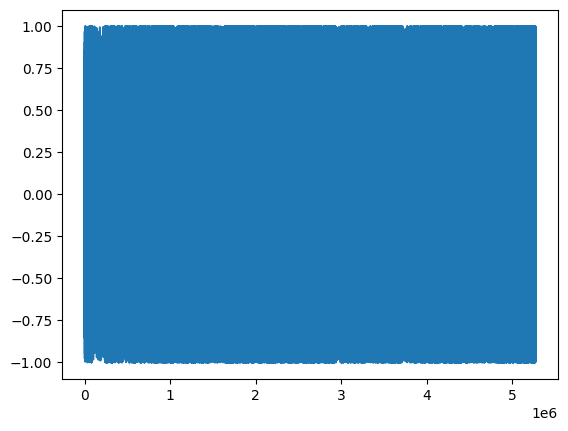

Number of values above 0.5: 2661970
Number of values below 0.5: 2608311


In [115]:
# based on the plot, we can see that the values are centered around 0 (even if linearly normalized)
# this will cause the next labeling step into inbalanced classes
# lets scale the values such that we'll have equal number of values above and below 0.5
# we'll do that by strech the signal towards the edges (-1 and 1) using parametric sigmoid function

import numpy as np


k = 5 # sigmoid function parameter

# stretch the signal towards the edges
x = df['current_trend']
x = 1 / (1 + np.exp(-k*x)) # values -> 0 to 1
x = 2*(x - 0.5) # values -> -1 to 1
df['current_trend_scaled'] = x

# plot the normalized values
df['current_trend_scaled'].plot()
plt.show()

# count the number of values with absolute value greater than 0.5
print('Number of values above 0.5:', len(df[df['current_trend_scaled'].abs() > 0.5]))
print('Number of values below 0.5:', len(df[df['current_trend_scaled'].abs() < 0.5]))

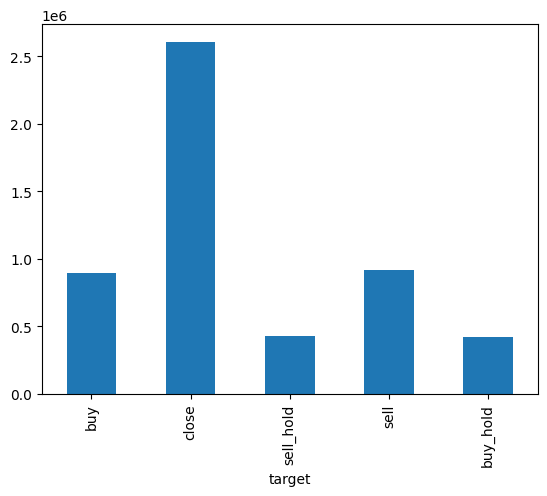

In [116]:
# Step 4: Create the Target Variable
# Range	Description	Recommended action
# [-1.00, -0.75]	Strong downward trend	    Sell
# (-0.75, -0.50]	Weak downward trend	        Sell hold
# (-0.50,  0.50)	Neutral	                    Close
# [ 0.50,  0.75)	Weak upwards trend	        Buy hold
# [ 0.75,  1.00]	Strong upwards trend	    Buy
import numpy as np

df['target'] = np.select(
    [
        df['current_trend_scaled'] <= -0.75,
        df['current_trend_scaled'] <= -0.50,
        df['current_trend_scaled'] <= 0.50,
        df['current_trend_scaled'] <= 0.75,
    ],
    [
        'sell',
        'sell_hold',
        'close',
        'buy_hold',
    ],
    default='buy'
)

# bar plot from the number of values in each class
df['target'].value_counts(sort=False).plot(kind='bar')
plt.show()

In [117]:


# Drop rows with NaN values in the target
df.dropna(inplace=True)

# Show the data after labeling (histogram of target labels)
df['target'].value_counts()



target
close        2608311
sell          915973
buy           898501
sell_hold     426659
buy_hold      420837
Name: count, dtype: int64

In [118]:
# define the features and target variable
features = ['close', 'volatility', 'ma_10', 'ma_30']
target = 'target'

X, y = df[features], df[target]

In [119]:
# (optional) we can clearly see that the data is imbalanced, we can use SMOTE to balance the data
# from imblearn.over_sampling import SMOTE

# # Apply SMOTE to balance the data
# smote = SMOTE(sampling_strategy='auto')
# X, y = smote.fit_resample(X, y)

# # Show the balanced target counts
# pd.Series(y).value_counts()

In [120]:
# Step 4: Train/Test Split
# Now we’ll split the dataset into training and testing sets. 

from sklearn.model_selection import train_test_split


# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shape of the training and testing sets
X_train.shape, X_test.shape


((4216224, 4), (1054057, 4))

In [121]:
# Step 5: Model Training
# We’ll train a machine learning model, such as a Random Forest classifier, on the training data.

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Display classification report to evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         buy       0.56      0.64      0.60    203733
    buy_hold       0.31      0.22      0.26     93126
       close       0.82      0.78      0.80    462539
        sell       0.54      0.65      0.59    202037
   sell_hold       0.32      0.25      0.28     92622

    accuracy                           0.63   1054057
   macro avg       0.51      0.51      0.50   1054057
weighted avg       0.63      0.63      0.63   1054057



In [122]:
# Step 6: Model Evaluation
# Evaluate the accuracy and other metrics to see how well the model performed on the test data.

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 63.22%


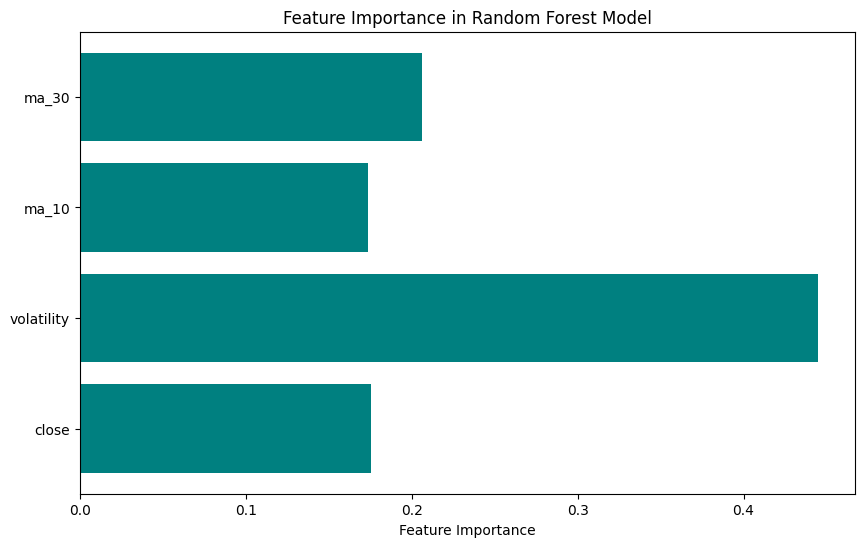

In [123]:
# Step 7: Feature Importance 
# we'll look at the importance of different features in the Random Forest model.

import matplotlib.pyplot as plt

# Get feature importances from the model
importances = model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='teal')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()


In [124]:
# save the model
import joblib

# Save the model as a pickle file
timestamp = pd.Timestamp.now().strftime('%Y-%m-%d-%H-%M-%S')
name = f'model_{timestamp}.pkl'
joblib.dump(model, name)
print(f"Model saved as {name}")

Model saved as model_2024-09-22-19-45-39.pkl


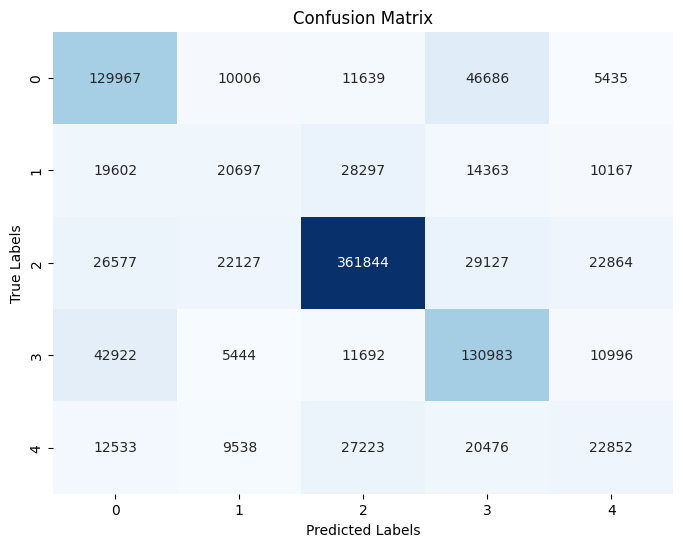

In [125]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
